# Team as an entity model

This model is a

In [2]:
# Import
from torch import nn
from torch.utils.data import DataLoader, random_split

from models.models import *
from datasets.datasets import *
from utils import *

In [3]:
# Meta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [4]:
file = './Data/team/processed/team_data.xlsx'
dataset = get_team_dataset(file)

# Dataloader

In [5]:
batch_size = 100
test_length = len(dataset)//10
train_length = len(dataset) - test_length


# TODO avoid contamination by training/testing with different players/teams

print(test_length)
print(train_length)
dataset_test, dataset_train = random_split(dataset, [test_length, train_length])


# Must generate batches of sequence data with the following format:
# (batch_size, num_seasons(N), input_size(num stats))
# (https://stackoverflow.com/questions/49466894/how-to-correctly-give-inputs-to-embedding-lstm-and-linear-layers-in-pytorch/49473068#49473068)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

print(dataset_train.__getitem__(0))

63
574
(tensor([[0.5910, 2.5000, 2.3200],
        [0.5790, 2.4400, 2.5900],
        [0.5300, 2.6700, 2.6100],
        [0.5670, 2.7300, 2.3800],
        [0.6650, 2.7100, 2.2200]]), tensor([0.5830, 2.6300, 2.2500]))


# Models

In [6]:
input_size = len(dataset_train.__getitem__(0)[0][0])
hidden_size = 50
#model = TeamAsEntity(input_size=input_size, hidden_size=hidden_size, device=device).to(device)

"""
Hidden Layers Size Exploration
"""
#hidden_sizes = [50, 100, 200]
hidden_sizes = [50]


"""
Stacked LSTM Exploration
"""
#num_layerss = [1,2,3]
num_layerss = [1, 2]

# Training and Validation

In [7]:
criterion = RMSELoss()
opt = torch.optim.Adam
epochs = 1500
loss_interval = 25

In [8]:
results = []

for hidden_size in hidden_sizes:
    for num_layers in num_layerss:

        print("\n####################")
        print(f"Model: {hidden_size}_{num_layers}")
        print("####################\n")

        model = TeamAsEntity(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, device=device).to(device)
        optimizer = opt(model.parameters(),lr=0.0001)
        
        res = train_and_validate(model, criterion, optimizer, dataloader_train, dataloader_test, epochs=epochs, loss_interval=loss_interval, device=device)
        results.append([(hidden_size,num_layers), res])


####################
Model: 50_1
####################



0 th epoch :  2.3956843614578247
Validation loss for epoch 0: 2.403754472732544
Validation loss for epoch 25: 1.647524356842041
50 th epoch :  1.355512022972107
Validation loss for epoch 50: 1.3632181882858276
Validation loss for epoch 75: 1.170661211013794
100 th epoch :  0.993424634138743
Validation loss for epoch 100: 1.0030732154846191
Validation loss for epoch 125: 0.8536423444747925
150 th epoch :  0.7130575577418009
Validation loss for epoch 150: 0.7205732464790344
Validation loss for epoch 175: 0.6041517853736877
200 th epoch :  0.4984181225299835
Validation loss for epoch 200: 0.5064894556999207
Validation loss for epoch 225: 0.43066731095314026
250 th epoch :  0.36894045273462933
Validation loss for epoch 250: 0.3786880075931549
Validation loss for epoch 275: 0.3492993116378784
300 th epoch :  0.3251136938730876
Validation loss for epoch 300: 0.33497095108032227
Validation loss for epoch 325: 0.3293508291244507
350 th epoch :  0.3134927103916804
Validation loss for epoch 350:

# Plot Results

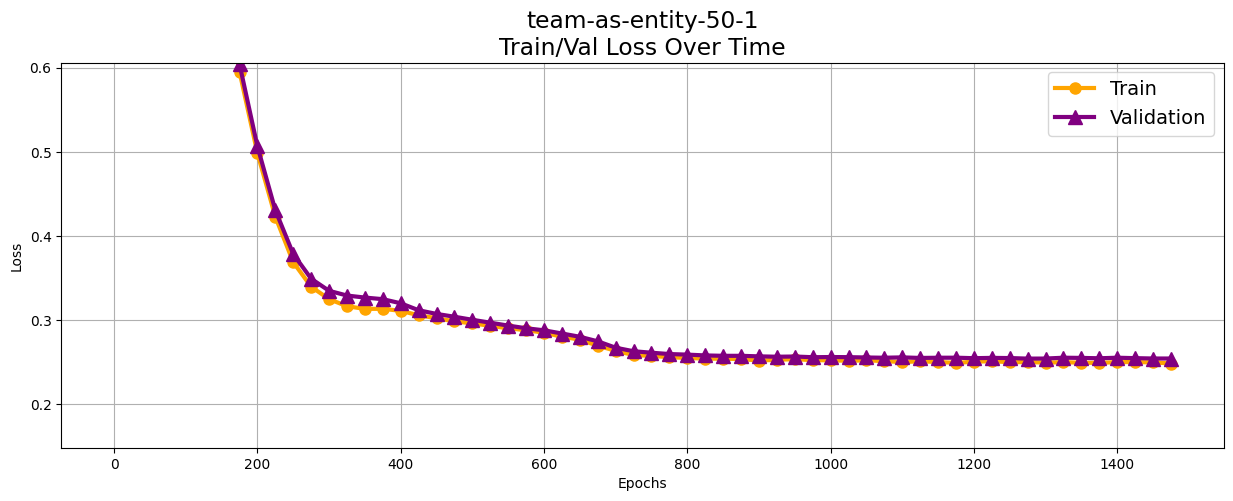

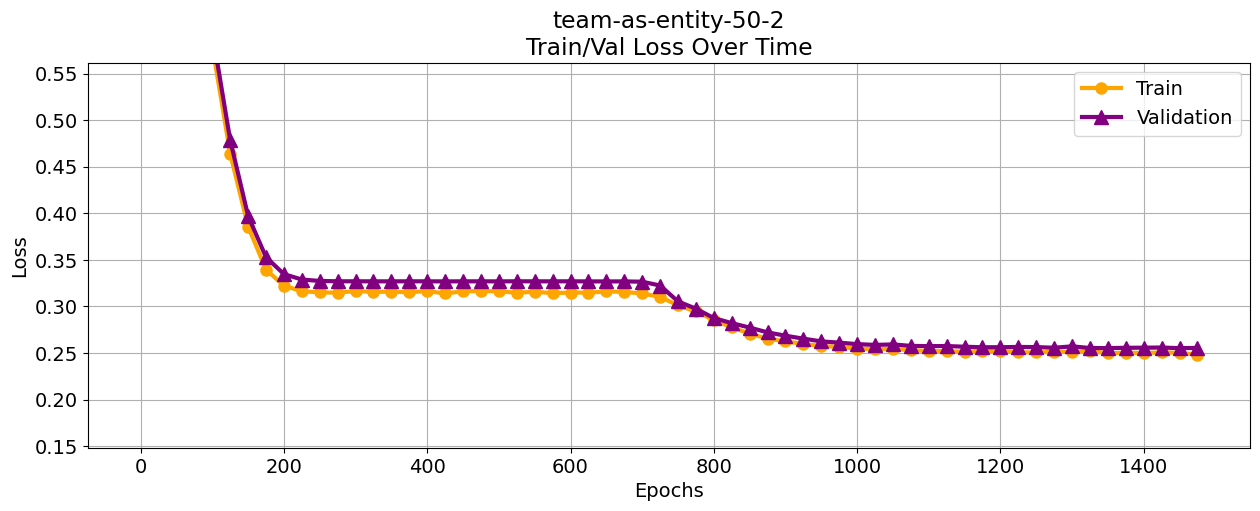

In [9]:
for res in  results:
    plot_train_v_loss(f"team-as-entity-{res[0][0]}-{res[0][1]}", res[1][1], res[1][2], loss_interval)

# Exploration results

Exploration for the team-as-entity model by varying the number of stacked LSTM layers and the number of hidden features. Apparently adding stacked LSTM layers for the same number of hidden features makes the loss decrease slower, but they all reach about the same loss plateau of 0.25. Adding more hidden layers makes the loss decrease faster, but once again it still plateau around 0.25. 

In [11]:
results = np.array(results, dtype=object)

print(results)

# Get all the target/pred pairs for the current model
NL = [5]
preds_n_targets = {}
for N in NL:
    preds_n_targets[N] = []

    for sample in dataset:
        pred = model(sample[0]) 
        preds_n_targets[N].append((sample[1], pred))

#print(results[:, 1:2])
trainslosses = results
vallosses = results[:][:][2]
plot_divergence(NL, preds_n_targets criterion)

[[(50, 1)
  (TeamAsEntity(
    (lstm): LSTM(3, 50, batch_first=True)
    (mid): Sequential(
      (0): Linear(in_features=50, out_features=200, bias=True)
      (1): Tanh()
      (2): Linear(in_features=200, out_features=12, bias=True)
      (3): Tanh()
    )
    (out): Linear(in_features=12, out_features=3, bias=True)
  ), [2.3956843614578247, 1.6458853681882222, 1.355512022972107, 1.1608605186144512, 0.993424634138743, 0.844410369793574, 0.7130575577418009, 0.5952264666557312, 0.4984181225299835, 0.42292018234729767, 0.36894045273462933, 0.339772825439771, 0.3251136938730876, 0.31665291885534924, 0.3134927103916804, 0.3135881970326106, 0.31117131809393567, 0.30593687295913696, 0.30240947504838306, 0.2987596243619919, 0.2962823212146759, 0.2933715383211772, 0.29047998289267224, 0.28819843133290607, 0.28521626194318134, 0.28044021626313526, 0.2769636313120524, 0.2697565406560898, 0.2637181207537651, 0.2586753765741984, 0.2576595867673556, 0.2561316291491191, 0.2552458470066388, 0.25442

IndexError: index 2 is out of bounds for axis 0 with size 2